In [1]:
# # Packages

import os
import random
from tqdm.notebook import tqdm
import pandas as pd

import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch.nn as nn
from torchsummary import summary
from torchvision.utils import save_image
import torch.nn.functional as F


from PIL import Image
from PIL import ImageFile
import matplotlib.pyplot as plt
import numpy as np
import random
ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline
import sklearn
from sklearn.metrics import confusion_matrix

#data, labels and classes
data= 'spectrograms/' #Change PATH as needed
labels='labels_extension.txt'
device = 'cuda'

data_content= os.listdir(data) #list of names of files for images

In [2]:
class SpectrogramDataset(Dataset):
    def __init__(self, path_dataset, path_labels):
        self.labels = open(path_labels, 'r').read().split('\n')
        self.path_dataset = path_dataset
        self.images = os.listdir(path_dataset)

    def __getitem__(self, index):
        image_return = np.array(Image.open(os.path.join(self.path_dataset, self.images[index])))
        label = self.labels[index]
        return torch.tensor(image_return), torch.tensor(float(int(label))).type(dtype=torch.int)

    def __len__(self):
        return len(self.labels)


In [3]:
#Define the model (RestNet18)

def get_model(pu):
    model = models.resnet152(weights=None)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(nn.Flatten(),
    nn.Linear(2048, 128),
    nn.Tanh(),
    nn.Dropout(0.2),
    nn.Linear(128, 1),
    nn.Sigmoid())
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-5)
    return model.to(pu), loss_fn, optimizer

In [4]:
#Loads the model

model, loss_fn, optimizer = get_model(device)
#summary(model, torch.zeros(1,3,224,224))

In [5]:
#Defining training and predecting functions

def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x).type(dtype=torch.float)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [6]:
dataset_s = SpectrogramDataset(data, labels)

all_indexes= np.array(range(len(dataset_s)))
random.seed(42)
random.shuffle(all_indexes)
n1 = int(0.8*len(all_indexes))
n2 = int(0.9*len(all_indexes))

indices_train = all_indexes[:n1]
indices_val = all_indexes[n1:n2]
indices_test = all_indexes[n2:]

In [7]:
#Saves checkpoints
def save_checkpoint(state, is_best, path, prefix, loss, filename='checkpoint.pth.tar', csvname = 'checkpoints/loss_train.csv'):
    prefix_save = os.path.join(path, prefix)
    name = prefix_save + '_' + filename
    torch.save(state, name)
    if is_best:
        shutil.copyfile(name, prefix_save + '_model_best.pth.tar')
    loss.to_csv(csvname)


  0%|          | 0/100 [00:00<?, ?it/s]

/home/aduque/.conda/envs/prosodyenv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


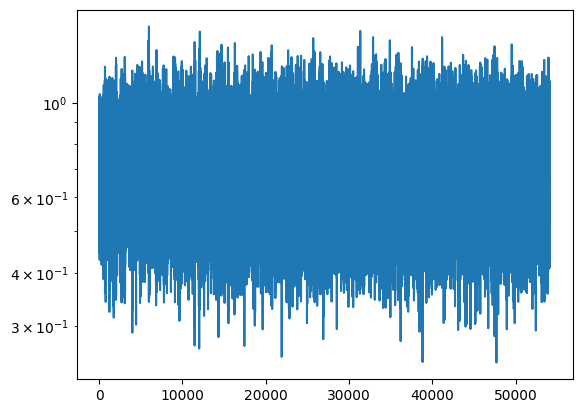

In [8]:
#Overfitting

random.seed(42)
dataset_s = SpectrogramDataset(data, labels)

loss_train = []
for i in tqdm(range(100)):
    all_indexes = np.array(range(len(dataset_s)))
    random.shuffle(all_indexes)
    for index in all_indexes:
        X, y= dataset_s[index]
        X= X.permute(2,0,1).float().unsqueeze(0).to(device)
        y= y.unsqueeze(0).unsqueeze(0).type(dtype=torch.float).to(device)
        loss= train_batch(X, y, model, optimizer, loss_fn)
        loss_train.append(loss)

plt.semilogy(loss_train)
plt.show()
iters_opt = torch.argmin(torch.tensor(loss_train))/len(dataset_s)


In [9]:
print(f'These are the optimal iterations{iters_opt}')

These are the optimal iterations88.11644744873047


In [10]:
#Training with optimal iterations 
random.seed(42)
dataset_s = SpectrogramDataset(data, labels)

loss_train = []
for i in tqdm(range(int(iters_opt))):
    all_indexes = np.array(range(len(dataset_s)))
    random.shuffle(all_indexes)
    for index in all_indexes:
        X, y= dataset_s[index]
        X= X.permute(2,0,1).float().unsqueeze(0).to(device)
        y= y.unsqueeze(0).unsqueeze(0).type(dtype=torch.float).to(device)
        loss= train_batch(X, y, model, optimizer, loss_fn)
        loss_train.append(loss)

  0%|          | 0/88 [00:00<?, ?it/s]

In [11]:
# Evaluating on TRAINING
import sklearn
from sklearn.metrics import confusion_matrix
all_indexes= np.array(range(len(dataset_s)))

model.eval()
predictions = []
actuals = []
for i in all_indexes:
    X, y= dataset_s[i]
    X = X.permute(2, 0, 1).float().unsqueeze(0).to(device)
    y = y.unsqueeze(0).unsqueeze(0).type(dtype=torch.float).to(device)
    prediction = model(X)
    predictions.append(int((prediction > 0.5).cpu().numpy()))
    actuals.append(y.cpu().numpy())

# Flatten the lists
predictions = np.asarray(predictions).flatten()

actuals = np.asarray(actuals).flatten()

# Compute confusion matrix
cm = confusion_matrix(actuals, predictions)


# Plot confusion matrix
#plt.figure(figsize=(8, 6))
#sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
#plt.xlabel('Predicted')
#plt.ylabel('Actual')
#plt.title('Confusion Matrix')
#plt.show()

/tmp/ipykernel_296364/90318055.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predictions.append(int((prediction > 0.5).cpu().numpy()))


In [13]:
#View metrics
tn, fp, fn, tp = confusion_matrix(actuals, predictions).ravel()
recall = float(tp) / (tp + fn)
precision= float(tp + tn) / (tp + fn + fp + tn)

print('Recall: {}'.format(recall)) 
print('Precision {}'.format(precision))
cm

Recall: 0.0
Precision 0.5397412199630314


array([[292,   0],
       [249,   0]])

In [20]:
#saving results 
import pandas as pd
results= {"pred": predictions, "actual": actuals}
data= pd.DataFrame(data=results)
data.to_csv("predictions_overfitting.csv")


In [ ]:
#Training of CNN

loss_train = []
loss_val =[]
for i in tqdm(range(1000)):
    for index in indices_train:
        X, y= dataset_s[index]
        X= X.permute(2,0,1).float().unsqueeze(0).to(device)
        y= y.unsqueeze(0).unsqueeze(0).type(dtype=torch.float).to(device)
        loss= train_batch(X, y, model, optimizer, loss_fn)
        loss_train.append(loss)

    for val_index in indices_val:
        X, y= dataset_s[val_index]
        X= X.permute(2,0,1).float().unsqueeze(0).to(device)
        y= y.unsqueeze(0).unsqueeze(0).type(dtype=torch.float).to(device)
        loss= train_batch(X, y, model, optimizer, loss_fn)
        loss_val.append(loss)

plt.semilogy(loss_train)
plt.semilogy(loss_val)
plt.show()
iters_opt = torch.argmin(torch.tensor(loss_val))
